## Installing packages
* pip install lightgbm
* conda install -c conda-forge xgboost
* pip install xgboost

## **EDA & ML**  

**Approaches and Techniques:**

* EDA with Pandas and Seaborn
* Find features with strong correlation to target variables questions and answers
* Data preprocessing, converting categorical features mainly (country) to numerical
* apply the basic Regression models of sklearn 
* use gridsearchCV to find the best parameters for each model
* compare the performance of the Regressors and choose best one

**The notebook is organized as follows:**

* **[Part 0: Imports, Settings and switches, Global functions](#Part-0-:-Imports,-Settings,-Functions)**  
* import libraries  
* settings for number of cross validations  
* define functions that are used often

* **[Part 1: Exploratory Data Analysis](#Part-1:-Exploratory-Data-Analysis)**  
1.1 Get an overview of the features (numerical and categorical) and first look on the target variables questions and answers
[shape, info, head and describe](#shape,-info,-head-and-describe)  
[Distribution of the target variable Q](#The-target-variable-:-Distribution-of-questions-and-answers)  
[Numerical and Categorical features](#Numerical-and-Categorical-features)  
[List of features with missing values](#List-of-features-with-missing-values) and Filling missing values using [log transform](#log-transform)  
1.2 Relation of all features to target questions and answers  
[Seaborn regression plots for numerical features](#Plots-of-relation-to-target-for-all-numerical-features)  
[List of numerical features and their correlation coefficient to target](#List-of-numerical-features-and-their-correlation-coefficient-to-target)  
[Seaborn boxplots for categorical features](#Relation-to-questions-and-answers-for-all-categorical-features)  
[List of categorical features and their unique values](#List-of-categorical-features-and-their-unique-values)  
1.3 Determine the columns that show strong correlation to target  
[Correlation matrix 1](#Correlation-matrix-1) : all numerical features determine features with largest correlation to questions and answers

* **[Part 2: Data wrangling](#Part-2:-Data-wrangling)**  
[Dropping all columns with weak correlation to questions and answers](#Dropping-all-columns-with-weak-correlation-to-questions-and-answers)  
[Convert categorical columns to numerical](#Convert-categorical-columns-to-numerical)  
[Checking correlation to questions and answers for the new numerical columns](#Checking-correlation-to-questions-and-answers-for-the-new-numerical-columns)  
use only features with strong correlation to target  
[Correlation Matrix 2 (including converted categorical columns)](#Correlation-Matrix-2-:-All-features-with-strong-correlation-to-questions-and-answers)  
Create datasets for ML algorithms:                                                                          
[OneHotEncoder](#OneHotEncoder)  
[StandardScaler](#StandardScaler)

* **[Part 3: Scikit-learn basic regression models and comparison of results](#Part-3:-Scikit-learn-basic-regression-models-and-comparison-of-results)**  
implement GridsearchCV with RMSE metric for Hyperparameter tuning for these models from sklearn:  
[Linear Regression](#Linear-Regression)  
[Ridge](#Ridge)  
[Lasso](#Lasso)  
[Elastic Net](#Elastic-Net)  
[Stochastic Gradient Descent](#SGDRegressor)  
[DecisionTreeRegressor](#DecisionTreeRegressor)  
[Random Forest Regressor](#RandomForestRegressor)  
[KNN Regressor](#KNN-Regressor)  
Baed on RMSE metric, compare performance of the regressors with their optimized parameters, then explore correlation of the predictions and make submission with mean of best models plot comparison:             
[RMSE of all models](#Comparison-plot:-RMSE-of-all-models)  
[Correlation of model results](#Correlation-of-model-results)  
Mean of best models

# Part 0 : Imports, Settings, Functions

In [1]:
%autosave 60
#Visualizing Lib
import seaborn as sns
import matplotlib.pyplot as plt

#Math Lib for some statistics
from scipy import stats
%matplotlib inline
sns.set()

# df preprocessing Lib
import pandas as pd
import numpy as np
pd.set_option('max_columns', 105)

# AI preprocessing lib
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
#import sklearn.impute.SimpleImputer
from sklearn.model_selection import train_test_split 

# ML Lib
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
import sklearn.linear_model as linear_model
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor

# warning supressor
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore")
#importing necessary models and libraries

Autosaving every 60 seconds


### Settings and switches

* Here we can choose settings for optimal performance and runtime. 
* For example, nr_cv sets the number of cross validations used in GridsearchCV, and min_val_corr is the minimum value for the correlation coefficient to the target (only features with larger correlation will be used). 

In [2]:
# setting the number of cross validations used in the Model part 
nr_cv = 5

# switch for using log values for questions, answers and features     
use_logvals = 1    
# target used for correlation 
target_1 = 'Questions_log'
target_2 = 'Answers_log'    
# only columns with correlation above this threshold value  
# are used for the ML Regressors in Part 3
min_val_corr = 0.4    
    
# switch for dropping columns that are similar to others already used and show a high correlation to these     
drop_similar = 1

## Initiate functions:

In [3]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    return best_score

def print_cols_large_corr(df, nr_c, targ) :
    corr = df.corr()
    corr_abs = corr.abs()
    print (corr_abs.nlargest(nr_c, targ)[targ])

def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

In [4]:
from subprocess import check_output, call 
print(check_output(["dir", "C:\\Data\\all.csv"],shell=True).decode("utf8"))

 Volume in drive C is Windows
 Volume Serial Number is 5843-B50F

 Directory of C:\Data

13/12/2019  11:06 AM        11,621,782 all.csv
               1 File(s)     11,621,782 bytes
               0 Dir(s)  355,997,425,664 bytes free



In [5]:
#Importing data into dataframe
df =  pd.read_csv('C://Data/all.csv')

In [6]:
#Displaying dataframe
df.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_PrivilegeWiki,p_TagWiki,p_TagWikiExerpt,p_Wiki,p_WikiPlaceholder,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_QuestionMerged,ph_PostMigrated,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionUnmerged,ph_PostDisassociated,ph_QuestionProtected,ph_SuggestedEditApplied,ph_UnknownDevRelatedEvent,ph_PostTweeted,ph_VoteNullificationByDev,ph_UnknownSuggestionEvent,ph_PostUnmigrated,ph_UnknownModeratorEvent,ph_UnknownEvent,ph_CommentDiscussionMovedToChat,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination,ph_PostMigratedHere
0,7784035,usa,1407.0,0.0,0,0,1,2,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9126518,usa,622.0,0.0,0,0,1,0,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10021482,usa,370.0,0.0,0,0,1,1,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2739419,usa,400.0,0.0,0,0,1,1,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1440631,usa,32.0,0.0,0,0,1,0,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print("-"*60)
print("List features with missing values and their percentage")
print("-"*60)
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

------------------------------------------------------------
List features with missing values and their percentage
------------------------------------------------------------


,Total,Percent
ph_PostMigratedHere,140184,1.000000
ph_UnknownSuggestionEvent,140184,1.000000
ph_QuestionMerged,140184,1.000000
ph_PostMigrated,140184,1.000000
p_Wiki,140184,1.000000
ph_QuestionUnmerged,140184,1.000000
ph_PostDisassociated,140184,1.000000
ph_SuggestedEditApplied,140184,1.000000
ph_UnknownDevRelatedEvent,140184,1.000000
ph_VoteNullificationByDev,140184,1.000000


In [8]:
print("Completely missing features (1.000000) will be eliminated as including them in the analysis will be useless as the rest of features will remain for now")

Completely missing features (1.000000) will be eliminated as including them in the analysis will be useless as the rest of features will remain for now


In [9]:
# subtitute missing values by zero
#df = df.fillna(0)
## Displaying modified dataframe
#df.head()
## creating a variable vector
# df = df.iloc[:,[0,6,7,8,9,10,11,12,13,14,15,16,17]]
## Or
# vec = df.loc[:,['Id','DisplayName','Location','country','AboutMe_length','activity_in_months','UpVotes','DownVotes','Reputation','Views','badges','Q_comments','A_comments','P_questions','P_answers']]
df.drop(['ph_PostMigratedHere','ph_UnknownSuggestionEvent','ph_QuestionMerged','ph_PostMigrated','ph_PostMigrated','p_Wiki','ph_QuestionUnmerged','ph_PostDisassociated','ph_SuggestedEditApplied','ph_UnknownDevRelatedEvent','ph_VoteNullificationByDev','ph_PostTweeted','ph_PostUnmigrated','ph_UnknownModeratorEvent','ph_UnknownEvent','ph_CommentDiscussionMovedToChat','p_PrivilegeWiki','p_WikiPlaceholder'], axis= 1, inplace=True);

In [10]:
df.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination
0,7784035,usa,1407.0,0.0,0,0,1,2,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9126518,usa,622.0,0.0,0,0,1,0,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10021482,usa,370.0,0.0,0,0,1,1,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2739419,usa,400.0,0.0,0,0,1,1,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1440631,usa,32.0,0.0,0,0,1,0,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Boxplot of numerical variables
* In this phase we will try to handle Outliers

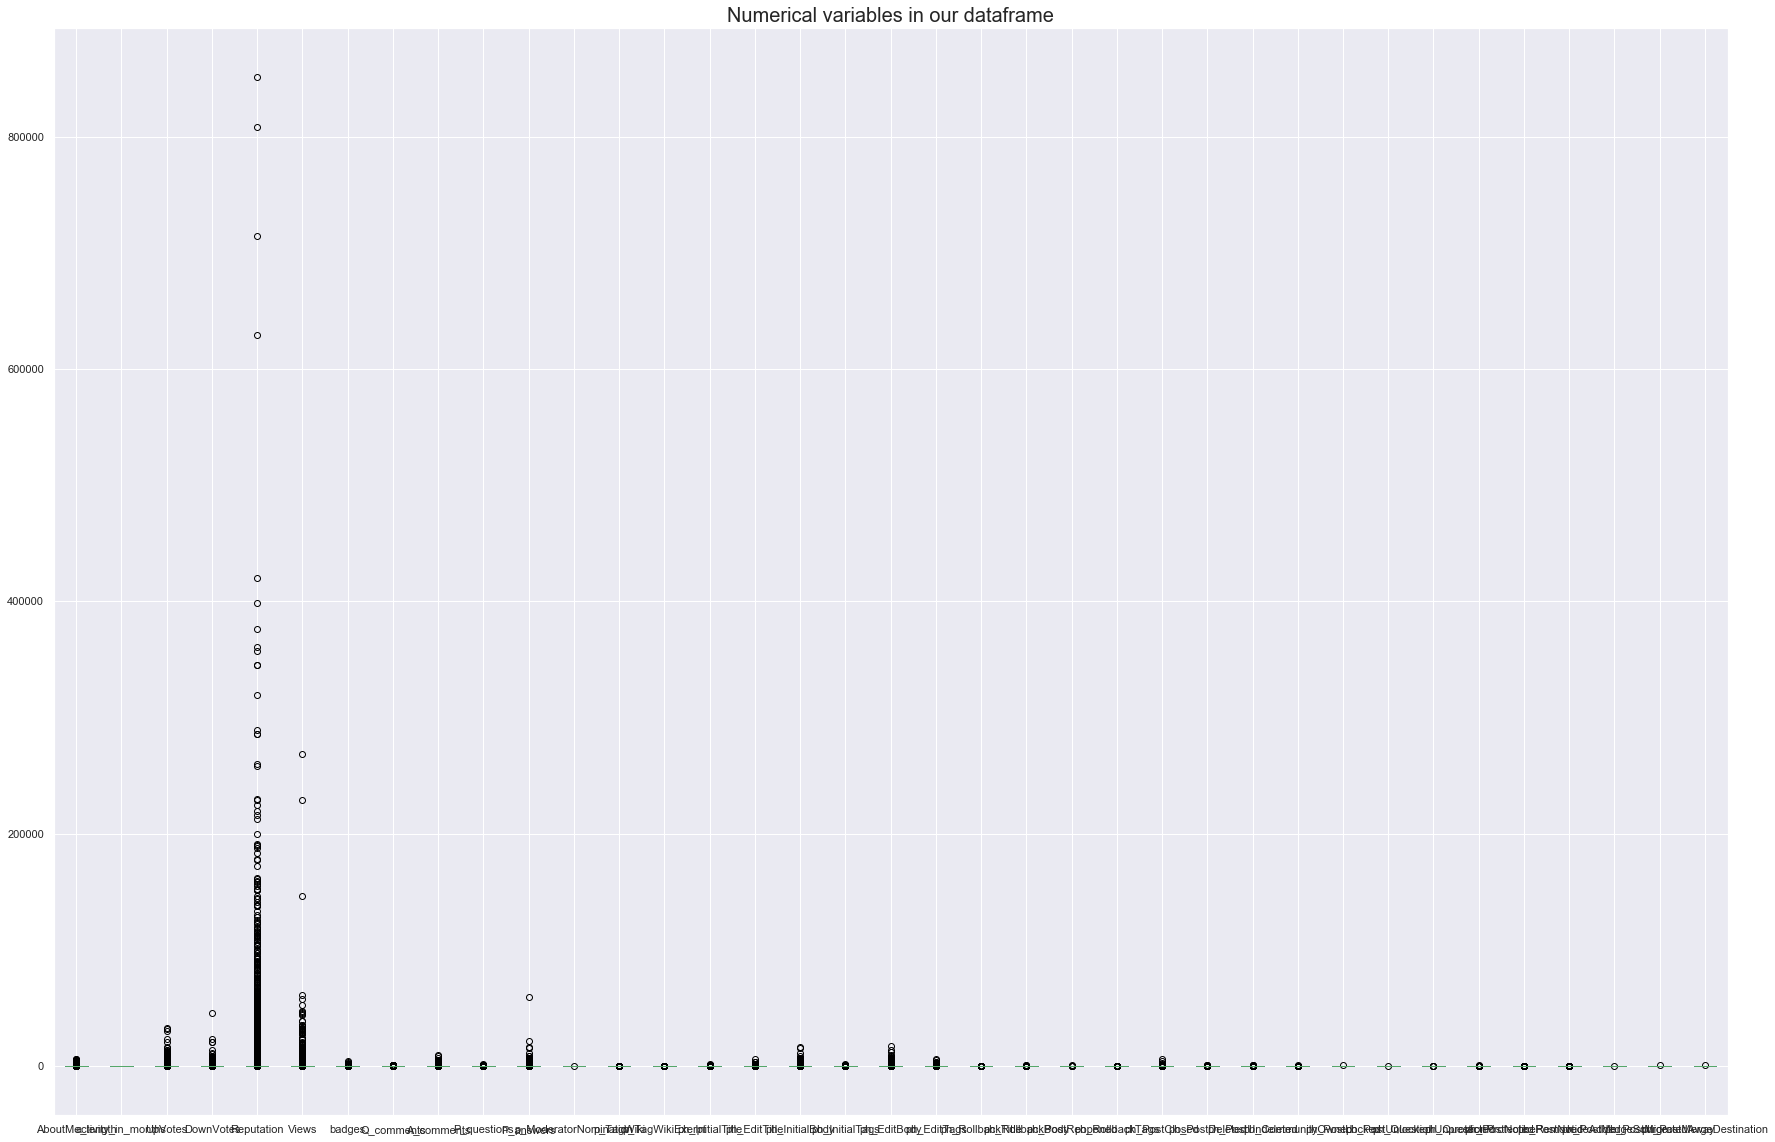

In [11]:
num_cols = ['AboutMe_length','activity_in_months','UpVotes','DownVotes','Reputation','Views','badges','Q_comments','A_comments','P_questions','P_answers','p_ModeratorNomination','p_TagWiki','p_TagWikiExerpt','ph_InitialTitle','ph_EditTitle','ph_InitialBody','ph_InitialTags','ph_EditBody','ph_EditTags','ph_RollbackTitle','ph_RollbackBody','ph_PostReopened','ph_RollbackTags','ph_PostClosed','ph_PostDeleted','ph_PostUndeleted','ph_CommunityOwned','ph_PostLocked','ph_PostUnlocked','ph_QuestionUnprotected','ph_QuestionProtected','ph_PostNoticeRemoved','ph_PostNoticeAdded','ph_PostMergeSource','ph_PostMigratedAway','ph_PostMergeDestination']
plt.figure(figsize=(30,20))
df[num_cols].boxplot()
plt.title("Numerical variables in our dataframe", fontsize=20)
plt.show()

In [12]:
# remove outliers using interquartile method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

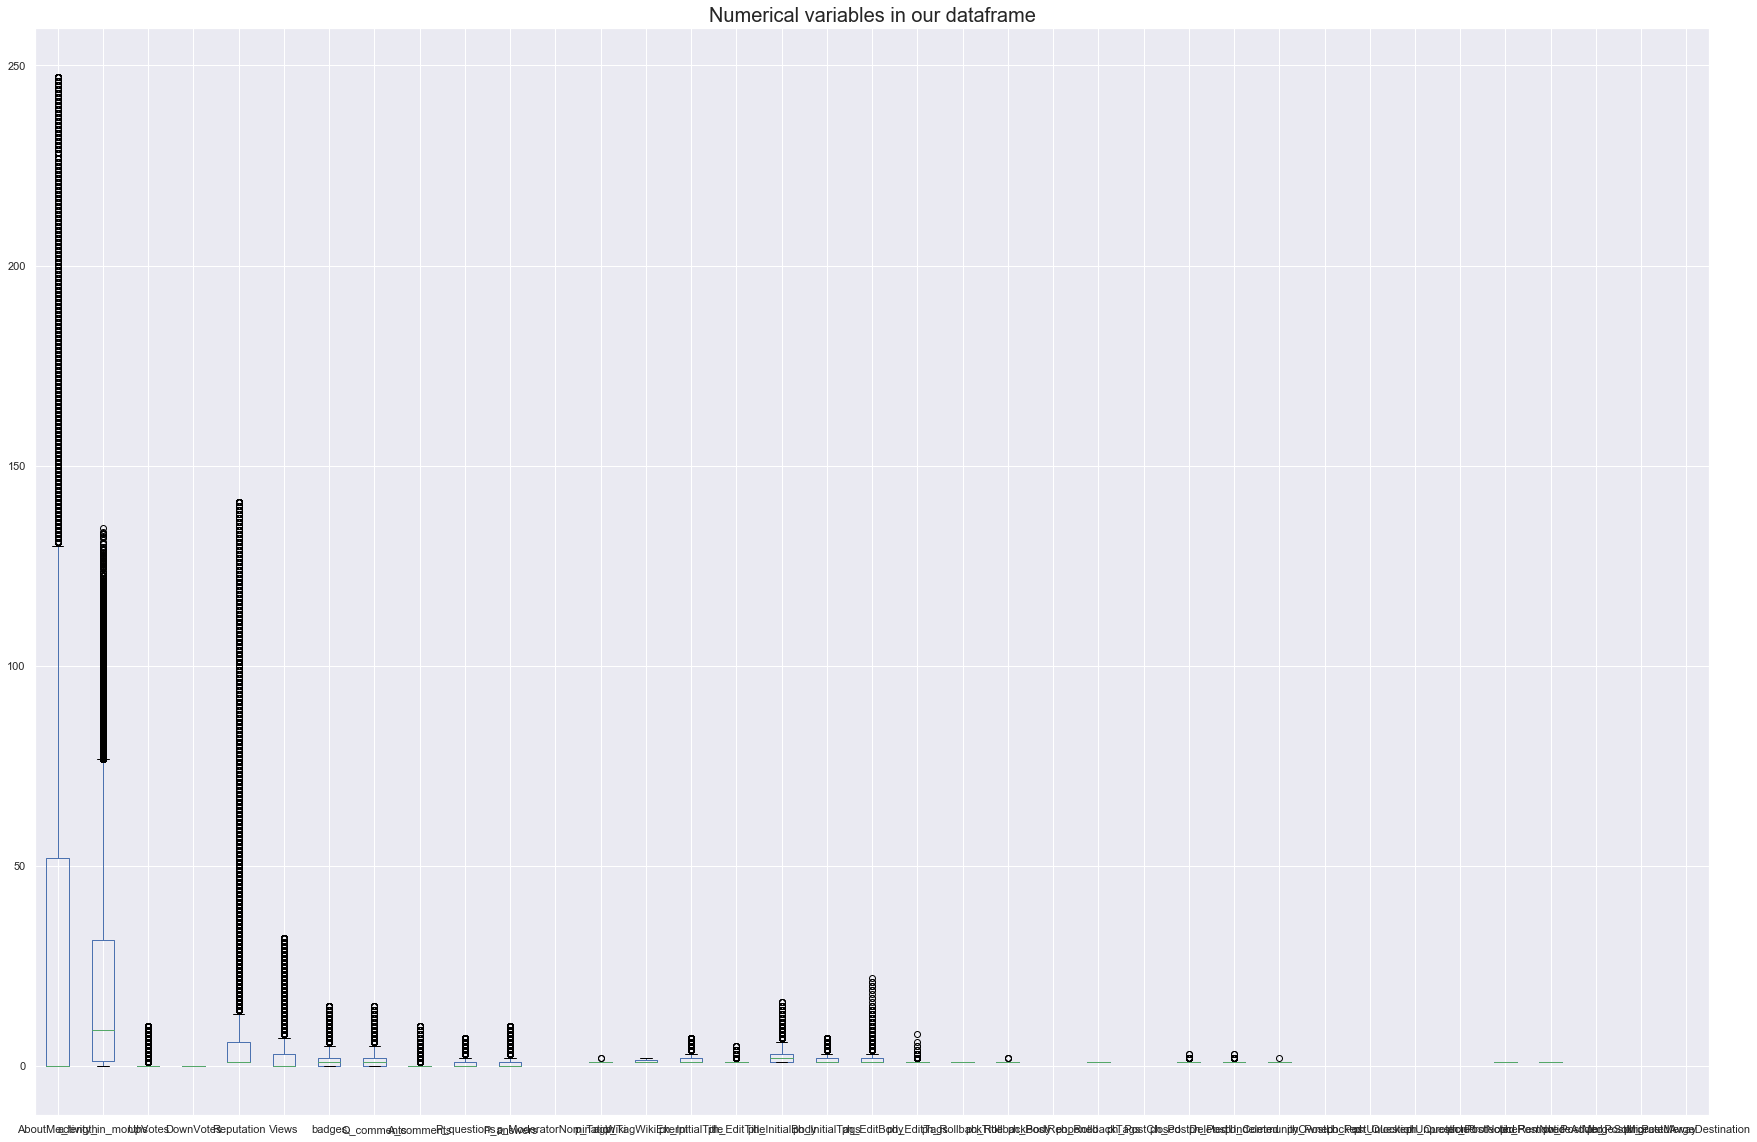

In [13]:
num_cols = ['AboutMe_length','activity_in_months','UpVotes','DownVotes','Reputation','Views','badges','Q_comments','A_comments','P_questions','P_answers','p_ModeratorNomination','p_TagWiki','p_TagWikiExerpt','ph_InitialTitle','ph_EditTitle','ph_InitialBody','ph_InitialTags','ph_EditBody','ph_EditTags','ph_RollbackTitle','ph_RollbackBody','ph_PostReopened','ph_RollbackTags','ph_PostClosed','ph_PostDeleted','ph_PostUndeleted','ph_CommunityOwned','ph_PostLocked','ph_PostUnlocked','ph_QuestionUnprotected','ph_QuestionProtected','ph_PostNoticeRemoved','ph_PostNoticeAdded','ph_PostMergeSource','ph_PostMigratedAway','ph_PostMergeDestination']
plt.figure(figsize=(30,20))
df[num_cols].boxplot()
plt.title("Numerical variables in our dataframe", fontsize=20)
plt.show()

In [14]:
# View each column seperately

# num_cols = ['Reputation']
# plt.figure(figsize=(20,15))
# df[num_cols].boxplot()
# plt.title("Numerical variables in our dataframe", fontsize=20)
# plt.show()

In [15]:
# df[df.Reputation > 600000]

In [16]:
# df[df.Views > 100000]

In [17]:
# df[df.P_answers > 50000]

In [18]:
# df[df.DownVotes > 30000]

In [19]:
# df.at[[77574,82886,84878,85942],'Reputation'] = None;
# df.at[[77574,84878,85942],'Views'] = None;
# df.at[[77574],'P_answers'] = None;
# df.at[[85524],'DownVotes'] = None;

In [20]:
# Create training and testing sets
df_train,df_test= train_test_split(df, test_size = 0.2, random_state = 0)

# Part 1: Exploratory Data Analysis

## 1.1 Overview of features and relation to target

Let's get a first overview of the train and test dataset
* How many rows and columns are there?  
* What are the names of the features (columns)?  
* Which features are numerical, which are categorical?  
* How many values are missing?  
The **shape** and **info** methods answer these questions. Whereas, the **head** displays some rows of the dataset **describe** gives a summary of the statistics (only for numerical columns)

### Shape, Info, Head & Describe -----> Functions

In [21]:
print('-'*100)
print('training sample size')
print(df_train.shape)
print('-'*100)
print('testing sample size')
print(df_test.shape)
print('-'*100)
print('training sample features description')
print(df_train.info())
print('-'*100)
print('testing sample features description')
print(df_train.info())
print('-'*100)

----------------------------------------------------------------------------------------------------
training sample size
(79168, 39)
----------------------------------------------------------------------------------------------------
testing sample size
(19793, 39)
----------------------------------------------------------------------------------------------------
training sample features description
<class 'pandas.core.frame.DataFrame'>
Int64Index: 79168 entries, 109971 to 100368
Data columns (total 39 columns):
Id                         79168 non-null int64
country                    79168 non-null object
AboutMe_length             41524 non-null float64
activity_in_months         79168 non-null float64
UpVotes                    79168 non-null int64
DownVotes                  79168 non-null int64
Reputation                 79168 non-null int64
Views                      79168 non-null int64
badges                     79168 non-null int64
Q_comments                 11830 non-null f

* It seems like the trainning and tesing dataframe *(df)* vector *(vec)* consists of 39 columns (38 features excluding Id), as for the training df vec, it has 112147 entries (number of rows). On the other hand,  df test vec has 28037 entries.  
* There are lots of info that is probably related to the dependent variables - > target (questions and answers) such as badges, reputaion, etc...   
* Maybe other features are not so important for predicting the target, also there might be a strong correlation for some of the features (like activity_in_month).
* There are missing in some columns and it seems some countries tend to have more missing data than others, we are going to deal with missing data accordingly in a later stage

In [22]:
# displaying a sample from the training dataframe
df_train.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination
109971,2756630,china,16.0,0.5,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27048,3704204,usa,63.0,4.9,0,0,26,5,7,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110677,2318915,china,NaN,59.2,0,0,11,1,2,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120629,2810372,china,18.0,6.3,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41089,1475614,usa,0.0,19.0,0,0,6,10,1,1.0,1.0,3.0,0.0,NaN,NaN,NaN,3.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# displaying a descriptive stats regarding the training dataframe 
df_train.describe()

,Id,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination
count,7.916800e+04,41524.000000,79168.000000,79168.000000,79168.0,79168.000000,79168.000000,79168.000000,11830.000000,11830.000000,52140.000000,50713.000000,0.0,10.000000,10.000000,14425.000000,951.000000,18587.000000,14425.000000,6837.000000,818.000000,7.0,31.000000,0.0,7.0,0.0,215.000000,225.000000,35.000000,0.0,0.0,0.0,0.0,5.0,12.0,0.0,0.0,0.0
mean,6.239934e+06,35.150853,20.358404,0.325119,0.0,9.018303,2.506758,1.550412,1.539053,0.360101,0.883122,0.600319,NaN,1.200000,1.200000,1.962565,1.189274,2.451122,1.962565,2.033494,1.134474,1.0,1.064516,NaN,1.0,NaN,1.097674,1.093333,1.028571,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
std,3.290332e+06,55.825783,25.198585,1.316225,0.0,20.621855,4.693243,2.065810,2.031318,0.955691,1.360038,1.280980,NaN,0.421637,0.421637,1.439330,0.546694,2.031501,1.439330,1.737672,0.473545,0.0,0.249731,NaN,0.0,NaN,0.312877,0.306478,0.169031,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
min,4.490000e+02,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,NaN,1.0,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
25%,3.243220e+06,0.000000,1.200000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,NaN,1.0,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
50%,7.106126e+06,0.000000,8.900000,0.000000,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,NaN,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.0,1.000000,NaN,1.0,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
75%,8.845459e+06,51.250000,31.200000,0.000000,0.0,6.000000,3.000000,2.000000,2.000000,0.000000,1.000000,1.000000,NaN,1.000000,1.000000,2.000000,1.000000,3.000000,2.000000,2.000000,1.000000,1.0,1.000000,NaN,1.0,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
max,1.200465e+07,247.000000,133.400000,10.000000,0.0,141.000000,32.000000,15.000000,15.000000,10.000000,7.000000,10.000000,NaN,2.000000,2.000000,7.000000,5.000000,16.000000,7.000000,22.000000,8.000000,1.0,2.000000,NaN,1.0,NaN,3.000000,3.000000,2.000000,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN


In [ ]:
# displaying a sample from the testing dataframe
df_test.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination
95218,11800498,china,NaN,1.1,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100551,11282081,china,NaN,3.4,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19647,3348823,usa,0.0,1.7,0,0,1,0,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25911,7294221,usa,NaN,4.3,0,0,1,0,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114015,9745160,china,0.0,9.5,0,0,1,2,2,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# displaying a descriptive stats regarding the testing dataframe
df_test.describe()

,Id,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination
count,1.979300e+04,10475.000000,19793.000000,19793.000000,19793.0,19793.000000,19793.000000,19793.000000,2975.000000,2975.000000,13006.000000,12645.000000,0.0,0.0,1.0,3582.000000,232.000000,4622.000000,3582.000000,1690.000000,204.000000,2.0,9.000000,0.0,2.0,0.0,55.000000,60.000000,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,6.230725e+06,35.411074,20.595867,0.312232,0.0,8.881322,2.481029,1.541302,1.534118,0.353277,0.875980,0.594227,NaN,NaN,2.0,1.972641,1.163793,2.449373,1.972641,2.027219,1.137255,1.0,1.111111,NaN,1.0,NaN,1.145455,1.133333,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,3.291763e+06,56.092905,25.425189,1.266492,0.0,20.416114,4.652665,2.054513,2.034362,0.980253,1.358555,1.275824,NaN,NaN,NaN,1.436676,0.517134,1.997708,1.436676,1.757795,0.525961,0.0,0.333333,NaN,0.0,NaN,0.404520,0.389118,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.640000e+02,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,2.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,NaN,1.0,NaN,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.230051e+06,0.000000,1.100000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,2.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,NaN,1.0,NaN,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,7.100880e+06,0.000000,8.900000,0.000000,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,2.0,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.0,1.000000,NaN,1.0,NaN,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,8.840549e+06,52.000000,32.500000,0.000000,0.0,6.000000,3.000000,2.000000,2.000000,0.000000,1.000000,1.000000,NaN,NaN,2.0,2.000000,1.000000,3.000000,2.000000,2.000000,1.000000,1.0,1.000000,NaN,1.0,NaN,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,1.200456e+07,247.000000,134.500000,10.000000,0.0,141.000000,32.000000,15.000000,15.000000,10.000000,7.000000,10.000000,NaN,NaN,2.0,7.000000,5.000000,14.000000,7.000000,17.000000,5.000000,1.0,2.000000,NaN,1.0,NaN,3.000000,3.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Distribution of target variables (Questions and Answers)

In [ ]:
## optimising plots size
# data = np.random.normal(0, 1, 3)
# array([-1.18878589,  0.59627021,  1.59895721])
# ploty = plt.figure(figsize=(20, 15))
# sns.boxplot(x=data);

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Skewness: 2.112230
Kurtosis: 4.764138
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


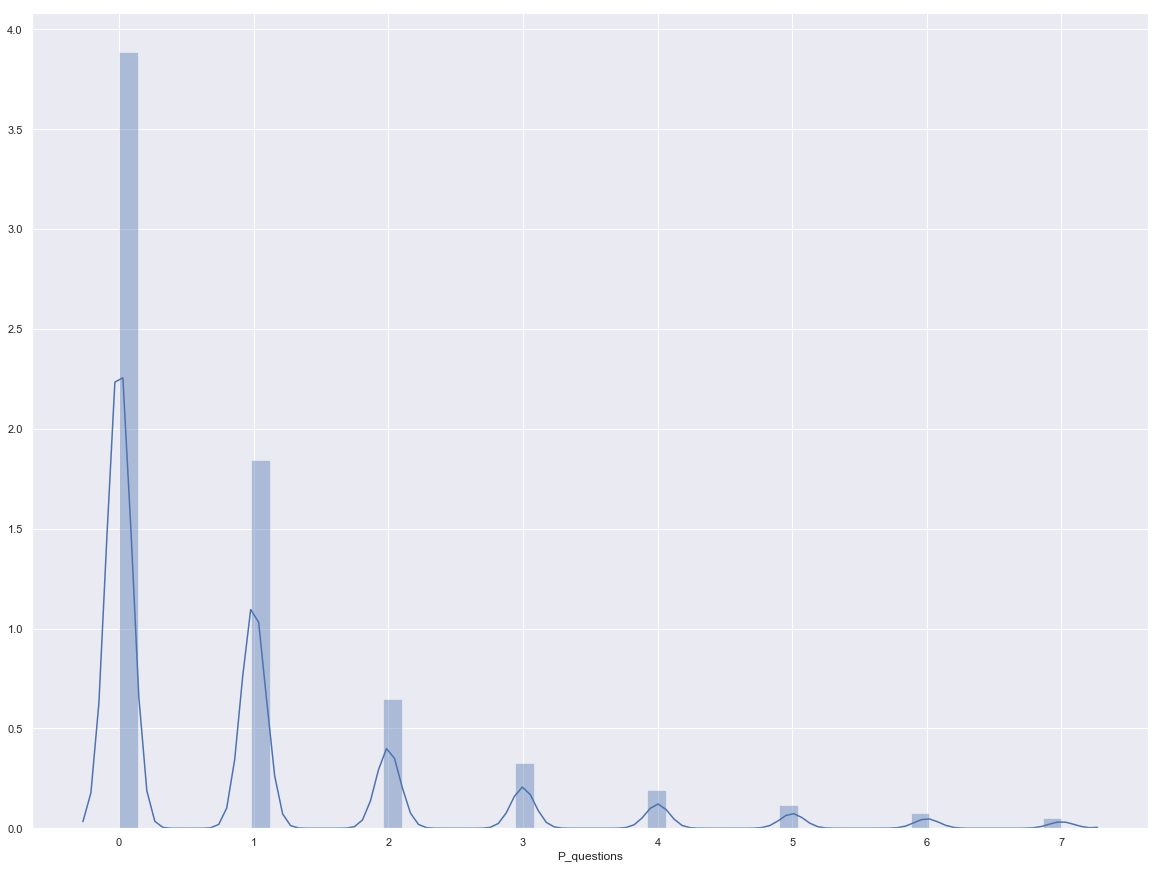

In [ ]:
# ~ conversion error prevention **
# df_train = df_train.fillna(0)
# Seaborn 0_0
print('-'*100)
print('-'*100)
plt.figure(figsize=(20, 15))
sns.distplot(df_train['P_questions'].dropna());
# skewness and Kurtosis
print("Skewness: %f" % df_train['P_questions'].skew());
print("Kurtosis: %f" % df_train['P_questions'].kurt());
print('-'*100)
print('-'*100)
# ValueError: cannot convert float NaN to integer --- Error --- just drop NaN or convertion is required ---> utilising fillna in early phase

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Skewness: 3.363767
Kurtosis: 14.233650
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


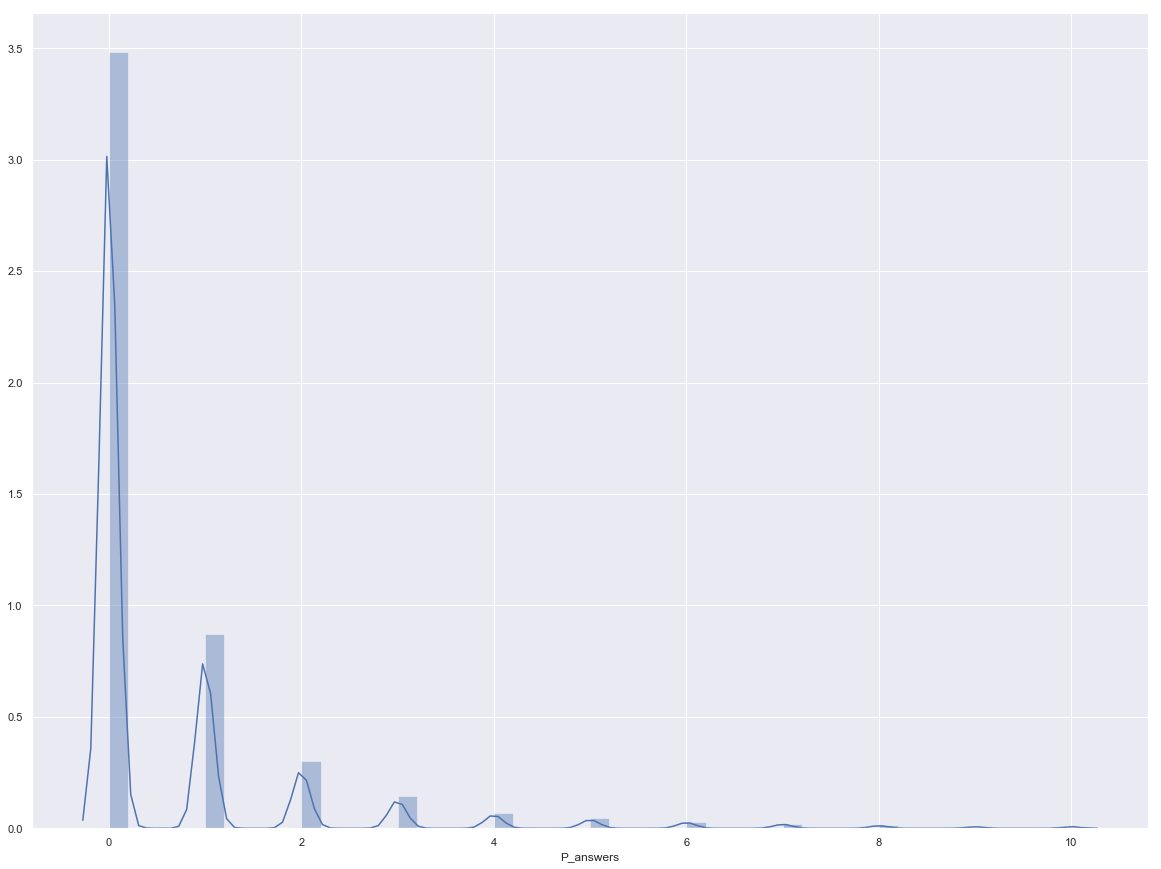

In [ ]:
print('-'*100)
print('-'*100)
plt.figure(figsize=(20, 15))
sns.distplot(df_train['P_answers'].dropna());
# skewness and Kurtosis
print("Skewness: %f" % df_train['P_answers'].skew());
print("Kurtosis: %f" % df_train['P_answers'].kurt());
print('-'*100)
print('-'*100)

* As we can see, the target variable for both questions and answers is not normally distributed. 
* This behaviour can leads to performance reduction in the ML regression modeling due the fact that some models assume normal distribution.
* Therfore a log transformation is required (ref: see sklearn info on preprocessing) to enhance distribution visualisation.
* Before running log transformation, we need to deal with zero values in questions and answers otherwise will face the error due to zero division which will produce -1nf (minus infinity)

In [ ]:
np.seterr(divide = 'ignore')
df_train['Questions_log'] = np.where(df_train.loc[:,['P_questions']]>0, np.log(df_train.loc[:,['P_questions']]), 0)
df_train['Answers_log'] = np.where(df_train.loc[:,['P_answers']]>0, np.log(df_train.loc[:,['P_answers']]), 0)

df_test['Questions_log'] = np.where(df_test.loc[:,['P_questions']]>0, np.log(df_test.loc[:,['P_questions']]), 0)
df_test['Answers_log'] = np.where(df_test.loc[:,['P_answers']]>0, np.log(df_test.loc[:,['P_answers']]), 0)

# # alternative implementation to avoids warnings.
# loc = np.where(myarray>0)
# result2 = np.zeros_like(myarray, dtype=float)
# result2[loc] =np.log(myarray[loc])

# # answer
# myarray= np.random.randint(10,size=10)
# result = np.where(myarray>0, np.log(myarray), 0)

# # check it is giving right solution:
# print(np.allclose(result, result2))

# append columns
# df_train = pd.concat([df_train, Questions_log], axis=1)

C:\Users\alamo248\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\alamo248\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\alamo248\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [ ]:
df_train.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination,Questions_log,Answers_log
109971,2756630,china,16.0,0.5,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
27048,3704204,usa,63.0,4.9,0,0,26,5,7,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
110677,2318915,china,NaN,59.2,0,0,11,1,2,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.098612
120629,2810372,china,18.0,6.3,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
41089,1475614,usa,0.0,19.0,0,0,6,10,1,1.0,1.0,3.0,0.0,NaN,NaN,NaN,3.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.098612,0.000000


In [ ]:
df_test.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,P_questions,P_answers,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination,Questions_log,Answers_log
95218,11800498,china,NaN,1.1,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
100551,11282081,china,NaN,3.4,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
19647,3348823,usa,0.0,1.7,0,0,1,0,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
25911,7294221,usa,NaN,4.3,0,0,1,0,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
114015,9745160,china,0.0,9.5,0,0,1,2,2,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.693147,0.0


----------------------------------------------------------------------------------------------------


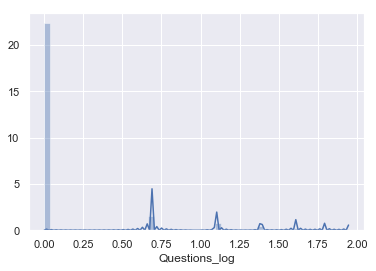

In [ ]:
sns.distplot(df_train['Questions_log'].dropna());
print('-'*100)

----------------------------------------------------------------------------------------------------


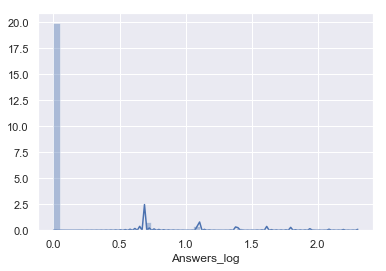

In [ ]:
sns.distplot(df_train['Answers_log'].dropna());
print('-'*100)

In [ ]:
print("-"*100)
print("Skewness and kurtosis for questions log")
print("Skewness: %f" % df_train['Questions_log'].skew());
print("Kurtosis: %f" % df_train['Questions_log'].kurt());
print("-"*100)

----------------------------------------------------------------------------------------------------
Skewness and kurtosis for questions log
Skewness: 2.852204
Kurtosis: 7.356069
----------------------------------------------------------------------------------------------------


In [ ]:
print("-"*100)
print("Skewness and kurtosis for answers log")
print("Skewness: %f" % df_train['Answers_log'].skew());
print("Kurtosis: %f" % df_train['Questions_log'].kurt());
print("-"*100)

----------------------------------------------------------------------------------------------------
Skewness and kurtosis for answers log
Skewness: 3.993260
Kurtosis: 7.356069
----------------------------------------------------------------------------------------------------


In [ ]:
print("Dropping old features from the loaded dataframe")
df_train.drop("P_questions",axis=1,inplace=True);
df_train.drop("P_answers",axis=1,inplace=True);
df_test.drop("P_questions",axis=1,inplace=True);
df_test.drop("P_answers",axis=1,inplace=True);

Dropping old features from the loaded dataframe


C:\Users\alamo248\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [ ]:
df_train.head()

,Id,country,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination,Questions_log,Answers_log
109971,2756630,china,16.0,0.5,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
27048,3704204,usa,63.0,4.9,0,0,26,5,7,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
110677,2318915,china,NaN,59.2,0,0,11,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.098612
120629,2810372,china,18.0,6.3,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
41089,1475614,usa,0.0,19.0,0,0,6,10,1,1.0,1.0,NaN,NaN,NaN,3.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.098612,0.000000


In [ ]:
print("-"*100)
print("Counting numerical and categorical features exist in the dataframe")
print("-"*100)
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of numerical features: ", len(numerical_feats));
categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of categorical features: ", len(categorical_feats));
print("-"*100)

----------------------------------------------------------------------------------------------------
Counting numerical and categorical features exist in the dataframe
----------------------------------------------------------------------------------------------------
Number of numerical features:  38
Number of categorical features:  1
----------------------------------------------------------------------------------------------------


In [ ]:
print("-"*35)
print("Displaying numerical features")
print("-"*35)
print(df_train[numerical_feats].columns)
print("-"*35)
print("Displaying categorical features")
print("-"*35)
print(df_train[categorical_feats].columns)

-----------------------------------
Displaying numerical features
-----------------------------------
Index(['Id', 'AboutMe_length', 'activity_in_months', 'UpVotes', 'DownVotes',
       'Reputation', 'Views', 'badges', 'Q_comments', 'A_comments',
       'p_ModeratorNomination', 'p_TagWiki', 'p_TagWikiExerpt',
       'ph_InitialTitle', 'ph_EditTitle', 'ph_InitialBody', 'ph_InitialTags',
       'ph_EditBody', 'ph_EditTags', 'ph_RollbackTitle', 'ph_RollbackBody',
       'ph_PostReopened', 'ph_RollbackTags', 'ph_PostClosed', 'ph_PostDeleted',
       'ph_PostUndeleted', 'ph_CommunityOwned', 'ph_PostLocked',
       'ph_PostUnlocked', 'ph_QuestionUnprotected', 'ph_QuestionProtected',
       'ph_PostNoticeRemoved', 'ph_PostNoticeAdded', 'ph_PostMergeSource',
       'ph_PostMigratedAway', 'ph_PostMergeDestination', 'Questions_log',
       'Answers_log'],
      dtype='object')
-----------------------------------
Displaying categorical features
-----------------------------------
Index(['country'

In [ ]:
print("-"*40)
print("Displaying numerical features dataframe")
print("-"*40)
df_train[numerical_feats].head()

----------------------------------------
Displaying numerical features dataframe
----------------------------------------


,Id,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination,Questions_log,Answers_log
109971,2756630,16.0,0.5,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
27048,3704204,63.0,4.9,0,0,26,5,7,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
110677,2318915,NaN,59.2,0,0,11,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.098612
120629,2810372,18.0,6.3,0,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
41089,1475614,0.0,19.0,0,0,6,10,1,1.0,1.0,NaN,NaN,NaN,3.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.098612,0.000000


In [ ]:
print("-"*40)
print("Displaying categorical features")
print("-"*40)
df_train[categorical_feats].head()

----------------------------------------
Displaying categorical features
----------------------------------------


,country
109971,china
27048,usa
110677,china
120629,china
41089,usa


In [ ]:
print("-"*40)
print("List features with missing values and their percentage")
print("-"*40)
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

----------------------------------------
List features with missing values and their percentage
----------------------------------------


,Total,Percent
ph_PostReopened,79168,1.000000
ph_QuestionProtected,79168,1.000000
p_ModeratorNomination,79168,1.000000
ph_PostClosed,79168,1.000000
ph_PostUnlocked,79168,1.000000
ph_QuestionUnprotected,79168,1.000000
ph_PostLocked,79168,1.000000
ph_PostMergeSource,79168,1.000000
ph_PostMigratedAway,79168,1.000000
ph_PostMergeDestination,79168,1.000000


## Filling missing values
* we have a few columns with a large percentage of NaN entries.

In [ ]:
# cols_fillna = ['A_comments','Q_comments','AboutMe_length']
# # replace 'NaN' with zero in these columns
# for col in cols_fillna:
#     df_train[col].fillna(0,inplace=True)
#     df_test[col].fillna(0,inplace=True)
#################################################
# subtitute missing values by zero
df_train = df_train.fillna(0)

In [ ]:
print("-"*40)
print("List features after handeling missing values")
print("-"*40)
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

----------------------------------------
List features after handeling missing values
----------------------------------------


,Total,Percent
Answers_log,0,0.0
Q_comments,0,0.0
ph_InitialBody,0,0.0
ph_EditTitle,0,0.0
ph_InitialTitle,0,0.0
p_TagWikiExerpt,0,0.0
p_TagWiki,0,0.0
p_ModeratorNomination,0,0.0
A_comments,0,0.0
badges,0,0.0


In [ ]:
print("-"*40)
print("Missing values in train data ?")
print("-"*40)
df_train.isnull().sum().sum()

----------------------------------------
Missing values in train data ?
----------------------------------------


0

In [ ]:
print("-"*40)
print("Missing values in test data ?")
print("-"*40)
df_train.isnull().sum().sum()

----------------------------------------
Missing values in test data ?
----------------------------------------


0

## log transform

* Like the target features, other features are not normally distributed therefore it is better to tranform those features using log in df_train and df_test. 

In [ ]:
print("-"*40)
print("Checking for skewness and kurtosis:")
print("-"*40)

for col in numerical_feats:
    print('{:25}'.format(col),'    ', 
          'Skewness: {:05.2f}'.format(df_train[col].skew()) , 
          '-------->' ,
          'Kurtosis: {:05.2f}'.format(df_train[col].kurt())  
         )

----------------------------------------
Checking for skewness and kurtosis:
----------------------------------------
Id                             Skewness: -0.17 --------> Kurtosis: -1.22
AboutMe_length                 Skewness: 02.87 --------> Kurtosis: 08.20
activity_in_months             Skewness: 01.43 --------> Kurtosis: 01.30
UpVotes                        Skewness: 04.88 --------> Kurtosis: 25.26
DownVotes                      Skewness: 00.00 --------> Kurtosis: 00.00
Reputation                     Skewness: 03.59 --------> Kurtosis: 13.66
Views                          Skewness: 02.94 --------> Kurtosis: 10.03
badges                         Skewness: 01.92 --------> Kurtosis: 04.26
Q_comments                     Skewness: 06.35 --------> Kurtosis: 52.59
A_comments                     Skewness: 10.97 --------> Kurtosis: 158.80
p_ModeratorNomination          Skewness: 00.00 --------> Kurtosis: 00.00
p_TagWiki                      Skewness: 105.50 --------> Kurtosis: 12366.09
p

In [ ]:
list(set(df_train.dtypes.tolist()))

[dtype('float64'), dtype('O'), dtype('int64')]

In [ ]:
df_num = df_train.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,Id,AboutMe_length,activity_in_months,UpVotes,DownVotes,Reputation,Views,badges,Q_comments,A_comments,p_ModeratorNomination,p_TagWiki,p_TagWikiExerpt,ph_InitialTitle,ph_EditTitle,ph_InitialBody,ph_InitialTags,ph_EditBody,ph_EditTags,ph_RollbackTitle,ph_RollbackBody,ph_PostReopened,ph_RollbackTags,ph_PostClosed,ph_PostDeleted,ph_PostUndeleted,ph_CommunityOwned,ph_PostLocked,ph_PostUnlocked,ph_QuestionUnprotected,ph_QuestionProtected,ph_PostNoticeRemoved,ph_PostNoticeAdded,ph_PostMergeSource,ph_PostMigratedAway,ph_PostMergeDestination,Questions_log,Answers_log
109971,2756630,16.0,0.5,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
27048,3704204,63.0,4.9,0,0,26,5,7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
110677,2318915,0.0,59.2,0,0,11,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.098612
120629,2810372,18.0,6.3,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
41089,1475614,0.0,19.0,0,0,6,10,1,1.0,1.0,0.0,0.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,0.000000


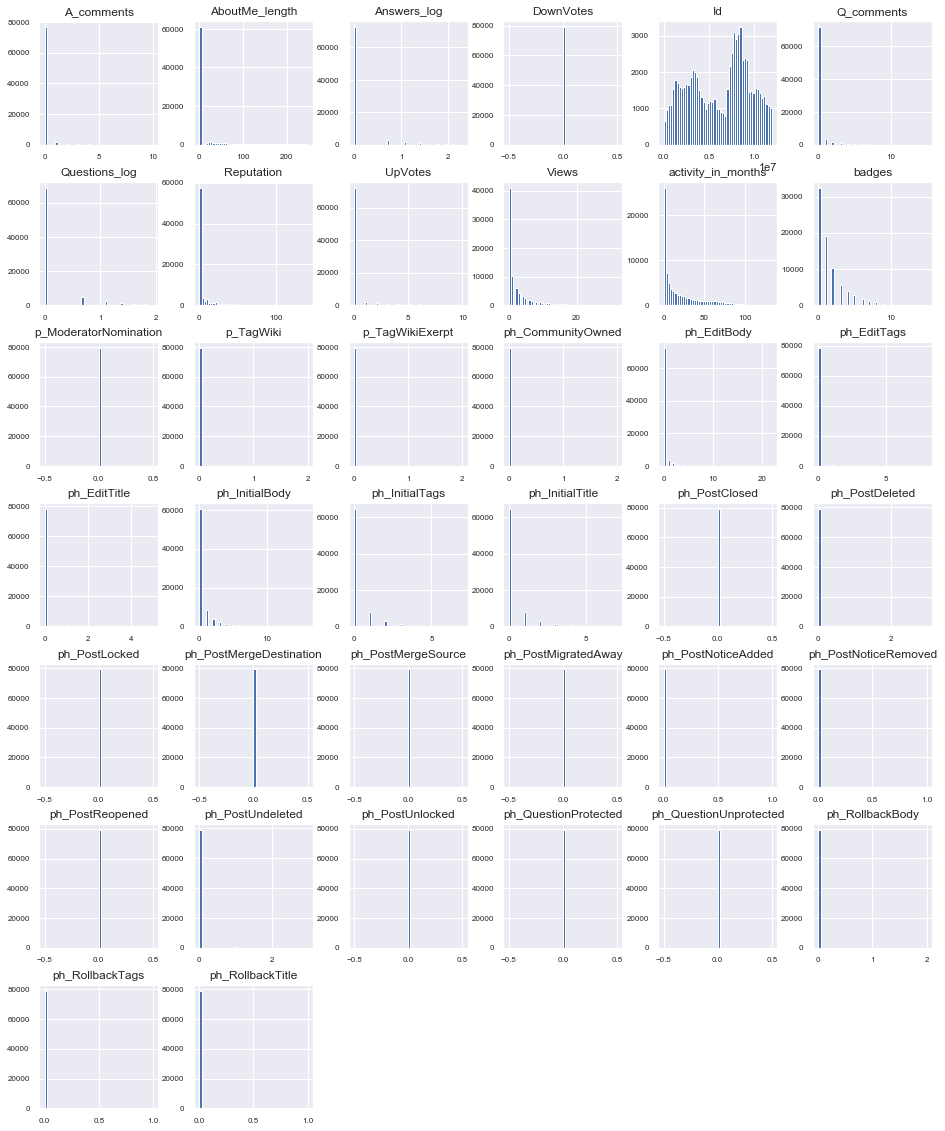

In [ ]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## 1.2 Relation of features to target (Questions_log and Answers_log)
### Plots of relation to target for all numerical features

C:\Users\alamo248\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


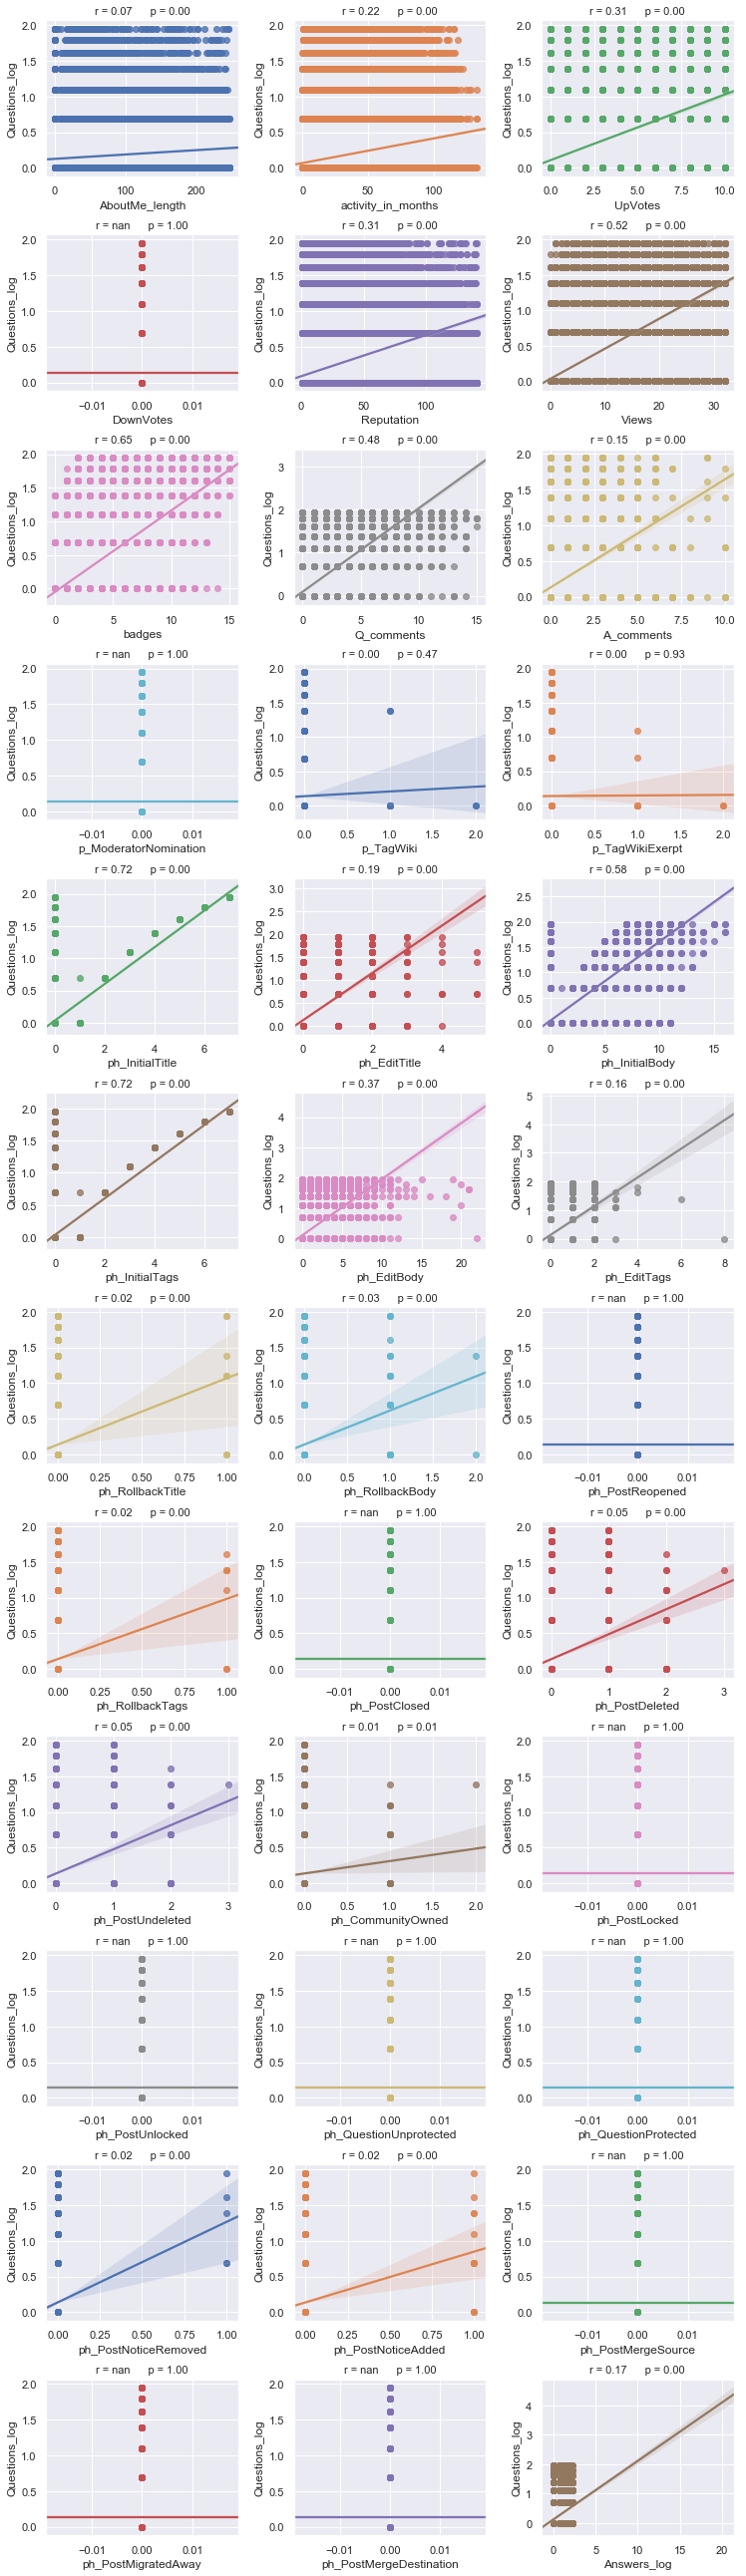

In [ ]:
nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'Questions_log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df_train[li_plot_num_feats[i]], df_train[target_1], ax = axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target_1])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   

In [ ]:
nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'Answers_log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df_train[li_plot_num_feats[i]], df_train[target_2], ax = axs[r][c])
            stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target_2])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()  

### List of numerical features and their correlation coefficient to target

**Find columns with strong correlation to target**  
Only those with r > min_val_corr are used in the ML Regressors in Part 3  
The value for min_val_corr can be chosen in global settings

In [ ]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target_1)[target_1]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [ ]:
print(ser_corr)
print("-"*100)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("-"*100)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

In [ ]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target_2)[target_2]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [ ]:
print(ser_corr)
print("-"*100)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("-"*100)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

### List of categorical features and their unique values

In [ ]:
print('-'*100)
for catg in list(categorical_feats) :
    print(df_train[catg].value_counts())
    print('-'*100)

### Relation to Questions and Answers for all categorical features

In [ ]:
li_cat_feats = list(categorical_feats)
nr_rows = 2
nr_cols = 2
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*5,nr_rows*4))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target_1, data=df_train, ax = axs[r][c])
plt.tight_layout()    
plt.show()  

In [ ]:
li_cat_feats = list(categorical_feats)
nr_rows = 2
nr_cols = 2
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*5,nr_rows*4))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target_2, data=df_train, ax = axs[r][c])
plt.tight_layout()    
plt.show()

### Correlation matrix 1
**Features with largest correlation to Questions_Log**  
all numerical features with correlation coefficient above threshold 

In [ ]:
nr_feats = len(cols_abv_corr_limit)
plot_corr_matrix(df_train, nr_feats, target_1)

### Correlation matrix 1
**Features with largest correlation to Answers_Log**  
all numerical features with correlation coefficient above threshold 

In [ ]:
nr_feats = len(cols_abv_corr_limit)
plot_corr_matrix(df_train, nr_feats, target_2)

* Of those features with the largest correlation to questions and answers, some also are correlated strongly to each other.
* To avoid failures of the ML regression models due to multicollinearity, these are dropped in part 2.
* This is optional and controlled by the switch drop_similar (global settings)

# Part 2: Data wrangling

* Drop all columns with only small correlation to P_questions and P_answers
* Transform Categorical to numerical
* Handling columns with missing data if it is needed
* Log values
* Drop all columns with strong correlation to similar features

### Dropping all columns with weak correlation to Questions and Answers

In [ ]:
id_test = df_test['Id']

to_drop_num  = cols_bel_corr_limit
# to_drop_catg = catg_weak_corr

cols_to_drop = ['Id'] + to_drop_num #+ to_drop_catg 

for df in [df_train, df_test]:
    df.drop(cols_to_drop, inplace= True, axis = 1)

### Convert categorical columns to numerical  
* We need to transform the country categorcial feature to numerical.
* To investigate the relation of the categorcial feature to target in more detail, we will create violinplots
* Also, we look at the mean of Questions and Answers as function of category.

In [ ]:
# Since we have one categorical value then we will take it as it is
catg_strong_corr = [ 'country']
catg_list = catg_strong_corr.copy()

In [ ]:
print(" "*43+"Violinplots btween Questions and Country")
print("-"*127)
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.violinplot(x='country', y=target_1, data=df_train, ax=ax)
plt.xticks(rotation=45)
plt.show()

In [ ]:
print(" "*43+"Violinplots btween Answers and Country")
print("-"*127)
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.violinplot(x='country', y=target_2, data=df_train, ax=ax)
plt.xticks(rotation=45)
plt.show()

In [ ]:
for catg in catg_list :
    g1 = df_train.groupby(catg)[target_1].mean()
    g2 = df_train.groupby(catg)[target_2].mean()
    print(g1)
    print(g2)

In [ ]:
# We are going to copy a country column then transform countries into integers and this can be done in different ways
# 'country'
country_catg2 = ['usa']
country_catg3 = ['china']
country_catg4 = ['russia']

In [ ]:
for df in [df_train, df_test]:   
    df['country_num'] = 1  
    df.loc[(df['country'].isin(country_catg2) ), 'country_num'] = 2
    df.loc[(df['country'].isin(country_catg3) ), 'country_num'] = 3
    df.loc[(df['country'].isin(country_catg4) ), 'country_num'] = 4

## Checking correlation to questions and answers for the new numerical columns¶

In [ ]:
new_col_num = ['country_num']

nr_rows = 2
nr_cols = 2

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(new_col_num):
            sns.regplot(df_train[new_col_num[i]], df_train[target_1], ax = axs[r][c])
            stp = stats.pearsonr(df_train[new_col_num[i]], df_train[target_1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()  

In [ ]:
new_col_num = ['country_num']

nr_rows = 2
nr_cols = 2

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(new_col_num):
            sns.regplot(df_train[new_col_num[i]], df_train[target_2], ax = axs[r][c])
            stp = stats.pearsonr(df_train[new_col_num[i]], df_train[target_2])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show() 

In [ ]:
# # dublicate column
dup = df_train['country_num']
# df_train['country_dum'] = df_train['country']
# df_train.head()
# # check data types 
# df_train["country_dum"] = df_train["country_dum"].astype('category')
# df_train.dtypes
# # create a new categorical dummy var from original
# df_train["country_dum1"] = df_train["country_dum"].cat.codes
# df_train.head()

In [ ]:
df_train.head()

In [ ]:
# check if the categorical conversion is correct, first convert the created country_num into list then loop through the list to see if the numbers adds up
cate = df_train['country_num'].tolist()

In [ ]:
# check numerical values for the categorical feature have changed correctly
print('-'*100)
usa = 0
china = 0
russia = 0
for column in cate:
    if column == 2: 
        usa +=1
    elif column == 3:
        china +=1
    else:
        russia+=4
print("usa = ",usa)
print("china = ",china)
print("russia = ",russia)
print('-'*100)

* Dropping the converted categorical column and the new numerical columns with weak correlation
* These will probably be useful for optimal performance of the Regressors in part 3.

In [ ]:
#catg_cols_to_drop = ['country']

corr1 = df_train.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(df_train)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, target_1)[target_1]
ser_corr_2 = corr_abs_1.nlargest(nr_all_cols, target_2)[target_2]
print("-"*100)
print(ser_corr_1)
print("-"*50)
print(ser_corr_2)
print("-"*100)

cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)
cols_bel_corr_limit_2 = list(ser_corr_2[ser_corr_2.values <= min_val_corr].index)

# for df in [df_train, df_test] :
#     df.drop(catg_cols_to_drop, inplace= True, axis = 1)
#     df.drop(cols_bel_corr_limit_1, inplace= True, axis = 1)    
#     df.drop(cols_bel_corr_limit_2, inplace= True, axis = 1)   

* It seems like country_num is weakly correlated with both Questions_log and Answers_log. However, the feature UpVotes is weakly correlated with Questions_log but this is not the case with Answers_log. Thus, we will keep it :)

In [ ]:
df_train.drop(['country','country_num'], inplace= True, axis = 1)
df_test.drop(['country','country_num'], inplace= True, axis = 1)

In [ ]:
corr2 = df_train.corr()
corr_abs_2 = corr2.abs()

nr_all_cols = len(df_train)
ser_corr_3 = corr_abs_2.nlargest(nr_all_cols, target_1)[target_1]
ser_corr_4 = corr_abs_2.nlargest(nr_all_cols, target_2)[target_2]

print("-"*100)
print(ser_corr_3)
print("-"*50)
print(ser_corr_4)
print("-"*100)

In [ ]:
df_train.head()

In [ ]:
df_test.head()

## Correlation Matrix 2 : 
* All features with strong correlation to Questions_log

In [ ]:
nr_feats=len(df_train.columns)
plot_corr_matrix(df_train, nr_feats, target_1)

In [ ]:
nr_feats=len(df_train.columns)
plot_corr_matrix(df_train, nr_feats, target_2)

In [ ]:
print('The number of samples into the train data is {}.'.format(df_train.shape[0]))

In [ ]:
print('The number of samples into the test data is {}.'.format(df_test.shape[0]))

In [ ]:
cols = corr_abs.nlargest(nr_all_cols, target)[target].index
cols = list(cols)

if drop_similar == 1 :
    for col in ['activity_in_months','1stFlrSF','TotRmsAbvGrd','GarageYrBlt'] :
        if col in cols: 
            cols.remove(col)

In [ ]:
# # create the independent variable vector
# x = df.iloc[:,6:15].values
# # Question dependent variable vector 
# y = df.iloc[:, -2:-1].values
# # Answer dependent variable vector 
# z = df.iloc[:,-1:].values
# # create labelEncoder object to transform categorical values into integers
# x[:, 0] = LabelEncoder().fit_transform(x[:, 0])
# y = LabelEncoder().fit_transform(y)
# z = LabelEncoder().fit_transform(z)
# # creating OneHotEncoder object to transform integer categorical values into dummy categorical
# x = OneHotEncoder(categorical_features=[0]).fit_transform(x).toarray()
# # Create training and testing sets
# x_train,x_test,y_train,y_test,z_train,z_test = train_test_split(x,y,z, test_size = 0.2, random_state = 0)
# # feature scaling
# sc_x = StandardScaler()
# x_train = sc_x.fit_transform(x_train)
# x_test = sc_x.transform(x_test)